In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
import optuna 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

## Preprocess

In [3]:
encoder = LabelEncoder()
scaler = MinMaxScaler()
cat_cols = ['Sex']
target = 'Rings'
continous_cols = [col for col in train.columns if col not in cat_cols + [target]]

train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.transform(test['Sex'])

train[continous_cols] = scaler.fit_transform(train[continous_cols])
test[continous_cols] = scaler.transform(test[continous_cols])

X = train.drop(columns=[target], axis=1)
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X.values, y.values, 
                                                  test_size=0.25, random_state=24)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

batch_size = 77
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Network

In [5]:
class NODEModel(nn.Module):
    """
    Neural Oblivious Decision Ensembles (NODE) model.
    """
    def __init__(self, input_dim, num_trees, depth):
        """
        Initialize the NODE model.
        
        Args:
            input_dim (int): Number of input features.
            num_trees (int): Number of decision trees in the ensemble.
            depth (int): Depth of each decision tree.
        """
        super(NODEModel, self).__init__()
        self.num_trees = num_trees
        self.depth = depth
        
        # Create a list of decision trees
        self.trees = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim, 2 ** depth),
            nn.ReLU(),
            nn.Linear(2 ** depth, 1)
        ) for _ in range(num_trees)])
    
    def forward(self, x):
        """
        Perform forward pass through the NODE model.
        
        Args:
            x (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Averaged predictions from all decision trees.
        """
        # Forward pass through each decision tree
        outputs = [tree(x).squeeze() for tree in self.trees]
        
        # Average the predictions from all trees
        return torch.mean(torch.stack(outputs), dim=0)

In [6]:
input_dim = X_train_tensor.shape[1]
params = {'num_trees': 106, 'depth': 8}

model = NODEModel(input_dim, **params).to(device)

## Train loop

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [1/35], Train Loss: 6.4168, Val Loss: 4.0156


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [2/35], Train Loss: 3.9602, Val Loss: 3.9107


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [3/35], Train Loss: 3.8828, Val Loss: 3.8432


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [4/35], Train Loss: 3.8249, Val Loss: 3.7477


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [5/35], Train Loss: 3.7922, Val Loss: 3.7769


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [6/35], Train Loss: 3.7576, Val Loss: 4.1135


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [7/35], Train Loss: 3.6891, Val Loss: 3.6864


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [8/35], Train Loss: 3.6819, Val Loss: 3.6894


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [9/35], Train Loss: 3.6772, Val Loss: 3.6809


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [10/35], Train Loss: 3.6748, Val Loss: 3.6788


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [11/35], Train Loss: 3.6735, Val Loss: 3.6831


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [12/35], Train Loss: 3.6692, Val Loss: 3.6733


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [13/35], Train Loss: 3.6590, Val Loss: 3.6715


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [14/35], Train Loss: 3.6589, Val Loss: 3.6715


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [15/35], Train Loss: 3.6578, Val Loss: 3.6709


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [16/35], Train Loss: 3.6573, Val Loss: 3.6735


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [17/35], Train Loss: 3.6566, Val Loss: 3.6701


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [18/35], Train Loss: 3.6571, Val Loss: 3.6715


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [19/35], Train Loss: 3.6563, Val Loss: 3.6701


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [20/35], Train Loss: 3.6554, Val Loss: 3.6699


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [21/35], Train Loss: 3.6555, Val Loss: 3.6699


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [22/35], Train Loss: 3.6552, Val Loss: 3.6698


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [23/35], Train Loss: 3.6555, Val Loss: 3.6698


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [24/35], Train Loss: 3.6549, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [25/35], Train Loss: 3.6553, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [26/35], Train Loss: 3.6561, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [27/35], Train Loss: 3.6554, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [28/35], Train Loss: 3.6565, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [29/35], Train Loss: 3.6557, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [30/35], Train Loss: 3.6558, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [31/35], Train Loss: 3.6553, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [32/35], Train Loss: 3.6552, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [33/35], Train Loss: 3.6552, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [34/35], Train Loss: 3.6561, Val Loss: 3.6697


  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Epoch [35/35], Train Loss: 3.6554, Val Loss: 3.6697


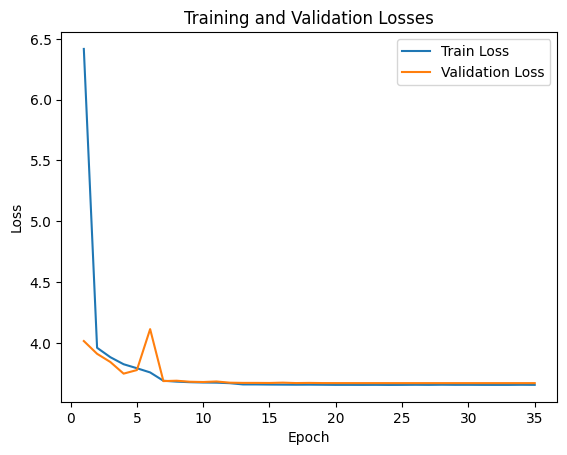

In [7]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize best_val_loss here
best_model_state = None
patience_counter = 0
early_stopping_patience = 5  # Define the patience for early stopping


EPOCHS = 35
initial_lr = 0.004  # Start with a small learning rate
lr_step_size = 6   # Update the learning rate every 6 epochs
lr_gamma = 0.1      # Multiply the learning rate by 0.1 every lr_step_size epochs
criterion = nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

train_losses = []
val_losses = []

for epoch in trange(EPOCHS):
    # Training phase
    avg_train_loss = []
    model.train()  # Set model to training mode
    for i, (image, mask) in enumerate(tqdm(train_loader)):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        avg_train_loss.append(loss.item())

    avg_train_loss = np.mean(avg_train_loss)

    # Validation phase
    avg_val_loss = []
    model.eval()  # Set model to evaluation mode
    for j, (image, mask) in enumerate(tqdm(val_loader)):
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            output = model(image)
            loss = criterion(output, mask)
            avg_val_loss.append(loss.item())

    avg_val_loss = np.mean(avg_val_loss)

     # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Apply learning rate scheduling
    scheduler.step()

    # Append the losses for this epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Create a DataFrame to store the losses
loss_df = pd.DataFrame({'val_loss': val_losses, 'train_loss': train_losses})

# Plot the losses
plt.plot(loss_df.index + 1, loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df.index + 1, loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## Inference

In [11]:
test_tensor = torch.tensor(test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    model.eval()
    predictions = model(test_tensor)
predictions

tensor([ 9.4968,  9.7810, 10.3299,  ..., 11.4436, 12.8023,  8.6803],
       device='cuda:0')

In [14]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
ids = sub['id']
submission_df = pd.DataFrame({'id':ids, 'Rings':predictions.cpu().numpy()})
submission_df.to_csv('submission.csv', index=False)
submission_df

,id,Rings
0,90615,9.496794
1,90616,9.781022
2,90617,10.329883
3,90618,10.275225
4,90619,7.674511
...,...,...
60406,151021,6.406685
60407,151022,9.402397
60408,151023,11.443598
60409,151024,12.802277


## Hyper parameter tuning

In [6]:
def train_model(X_train_tensor, y_train_tensor, params):
    """
    Train the FT-Transformer model with the given hyperparameters.
    
    Args:
        X_train_tensor (torch.Tensor): Input training data tensor.
        y_train_tensor (torch.Tensor): Target training data tensor.
        params (dict): Hyperparameters for the model.
        
    Returns:
        float: Average validation RMSE across folds.
    """
    # Unpack the hyperparameters
    input_dim = X_train_tensor.shape[1]
    num_trees = params['num_trees']
    depth = params['depth']
    num_epochs = 35 
    batch_size = params['batch_size']
    early_stopping_patience = params['early_stopping_patience']
    
    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the FT-Transformer model
    model = NODEModel(input_dim, num_trees, depth).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Create KFold cross-validator
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    best_val_rmse_folds = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold [{fold+1}/3]")

        # Create train and validation datasets using the indices
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset = torch.utils.data.TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])

        # Create data loaders for train and validation datasets
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

        # Initialize variables for early stopping
        best_val_rmse = float('inf')  # Initialize best_val_rmse here
        best_model_state = None
        patience_counter = 0

        # Training loop
        for epoch in tqdm(range(num_epochs)):
            model.train()
            
            # Iterate over the training batches
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_predictions = []
            val_targets = []
            
            # Iterate over the validation batches
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_predictions.append(outputs.squeeze().cpu().numpy())
                    val_targets.append(batch_y.cpu().numpy())
            
            # Concatenate the validation predictions and targets
            val_predictions = np.concatenate(val_predictions)
            val_targets = np.concatenate(val_targets)
            
            # Calculate validation RMSE
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation RMSE: {val_rmse:.4f}")
            
            # Check for early stopping
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Store the best validation RMSE for the current fold
        best_val_rmse_folds.append(best_val_rmse)
        
        # Load the best model state for the current fold
        model.load_state_dict(best_model_state)
    
    # Calculate the average validation RMSE across all folds
    avg_val_rmse = np.mean(best_val_rmse_folds)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")
    
    return avg_val_rmse

# Define objective function for Optuna
def objective(trial):
    """
    Objective function for hyperparameter optimization.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        
    Returns:
        float: Average validation RMSE.
    """
    # Define the hyperparameter search space
    params = {
        'num_trees': trial.suggest_int('num_trees', 50, 200),
        'depth': trial.suggest_int('depth', 4, 8),
        'batch_size': trial.suggest_int('batch_size', 16, 128),
        'early_stopping_patience': 6
    }
    
    # Train the model with the current hyperparameters
    avg_val_rmse = train_model(X_train_tensor, y_train_tensor, params)
    
    return avg_val_rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

# Optimize the hyperparameters
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2024-04-17 19:04:36,757] A new study created in memory with name: no-name-dbcb894c-1d75-4017-b744-5b0694c81583


Fold [1/3]


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [1/35], Validation RMSE: 2.4159
Epoch [2/35], Validation RMSE: 2.2853
Epoch [3/35], Validation RMSE: 2.1511
Epoch [4/35], Validation RMSE: 2.0636
Epoch [5/35], Validation RMSE: 2.0175
Epoch [6/35], Validation RMSE: 2.0071
Epoch [7/35], Validation RMSE: 1.9958
Epoch [8/35], Validation RMSE: 1.9986
Epoch [9/35], Validation RMSE: 1.9840
Epoch [10/35], Validation RMSE: 1.9803
Epoch [11/35], Validation RMSE: 1.9783
Epoch [12/35], Validation RMSE: 1.9730
Epoch [13/35], Validation RMSE: 1.9780
Epoch [14/35], Validation RMSE: 1.9658
Epoch [15/35], Validation RMSE: 1.9629
Epoch [16/35], Validation RMSE: 1.9624
Epoch [17/35], Validation RMSE: 1.9577
Epoch [18/35], Validation RMSE: 1.9994
Epoch [19/35], Validation RMSE: 1.9611
Epoch [20/35], Validation RMSE: 1.9510
Epoch [21/35], Validation RMSE: 1.9604
Epoch [22/35], Validation RMSE: 1.9655
Epoch [23/35], Validation RMSE: 1.9444
Epoch [24/35], Validation RMSE: 1.9524
Epoch [25/35], Validation RMSE: 1.9426
Epoch [26/35], Validation RMSE: 1.

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [1/35], Validation RMSE: 1.8999
Epoch [2/35], Validation RMSE: 1.8907
Epoch [3/35], Validation RMSE: 1.8938
Epoch [4/35], Validation RMSE: 1.9022
Epoch [5/35], Validation RMSE: 1.8908
Epoch [6/35], Validation RMSE: 1.8894
Epoch [7/35], Validation RMSE: 1.8900
Epoch [8/35], Validation RMSE: 1.8958
Epoch [9/35], Validation RMSE: 1.8903
Epoch [10/35], Validation RMSE: 1.8955
Epoch [11/35], Validation RMSE: 1.9118
Epoch [12/35], Validation RMSE: 1.8868
Epoch [13/35], Validation RMSE: 1.8881
Epoch [14/35], Validation RMSE: 1.8837
Epoch [15/35], Validation RMSE: 1.8939
Epoch [16/35], Validation RMSE: 1.8850
Epoch [17/35], Validation RMSE: 1.8814
Epoch [18/35], Validation RMSE: 1.8907
Epoch [19/35], Validation RMSE: 1.9102
Epoch [20/35], Validation RMSE: 1.8815
Epoch [21/35], Validation RMSE: 1.8954
Epoch [22/35], Validation RMSE: 1.8862
Epoch [23/35], Validation RMSE: 1.8799
Epoch [24/35], Validation RMSE: 1.8857
Epoch [25/35], Validation RMSE: 1.8822
Epoch [26/35], Validation RMSE: 1.

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [1/35], Validation RMSE: 1.8983
Epoch [2/35], Validation RMSE: 1.9011
Epoch [3/35], Validation RMSE: 1.8994
Epoch [4/35], Validation RMSE: 1.8950
Epoch [5/35], Validation RMSE: 1.8958
Epoch [6/35], Validation RMSE: 1.9059
Epoch [7/35], Validation RMSE: 1.9099
Epoch [8/35], Validation RMSE: 1.8969
Epoch [9/35], Validation RMSE: 1.9019


[I 2024-04-17 19:32:02,820] Trial 0 finished with value: 1.9021824598312378 and parameters: {'num_trees': 106, 'depth': 8, 'batch_size': 98}. Best is trial 0 with value: 1.9021824598312378.


Epoch [10/35], Validation RMSE: 1.8955
Early stopping at epoch 10
Average Validation RMSE across folds: 1.9022
Fold [1/3]


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [1/35], Validation RMSE: 2.4794
Epoch [2/35], Validation RMSE: 2.3884


[W 2024-04-17 19:35:32,524] Trial 1 failed with parameters: {'num_trees': 140, 'depth': 4, 'batch_size': 33} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/373353929.py", line 132, in objective
    avg_val_rmse = train_model(X_train_tensor, y_train_tensor, params)
  File "/tmp/ipykernel_34/373353929.py", line 67, in train_model
    optimizer.step()
  File "/opt/conda/lib/python3.10/site-packages/torch/optim/optimizer.py", line 373, in wrapper
    out = func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/optim/adam.py", line 163, in step
    adam(
  File "/opt/conda/lib/python3.10/site-packages/torch/optim/adam.py", line 311, in adam

KeyboardInterrupt: 